In [34]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns 
from pathlib import Path
from math import isnan, ceil

import matplotlib.pyplot as plt

from graphframes import *

########## START - PYSPARK ##########
from pyspark import SparkContext, SparkConf

from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import col, expr, count, to_timestamp, monotonically_increasing_id, \
    desc, sum as _sum, min as _min, max as _max, rand, when, \
    datediff, dayofmonth, weekofyear, month, year, hour, dayofweek, \
    unix_timestamp, array, lit, round as _round

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer 
########## END - PYSPARK ##########

spark = SparkSession.builder \
    .appName("AMD-SM2L Joint Project") \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("OFF")
train = spark.read.parquet("src/datasets/reduced_train_C.0050.parquet", header=True)
test = spark.read.parquet("src/datasets/reduced_test_C.0050.parquet", header=True)
#validation = spark.read.parquet("src/datasets/reduced_validation_C.0050.parquet", header=True)

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import math
import itertools
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from enum import Enum

class SplitCriterion(Enum):
    GINI = ('gini', lambda probability: 1 - np.sum(probability ** 2))
    MISCLASSIFICATION = ('misclassification', lambda probability: 1 - np.max(probability))
    SHANNON = ('shannon', lambda probability: -np.sum(probability * np.log2(probability)))
    ENTROPY = ('entropy', lambda probability: -np.sum(probability * np.log2(probability + 1e-10)))
    CHI_SQUARED = ('chi_square', lambda probability: np.sum(((probability - np.mean(probability)) ** 2) / np.mean(probability)))
    
class Node:
    def __init__(self, feature=None, threshold=None, info_gain=None, left=None, right=None, value=None):
        """
        Create a Node object for a decision tree.

        Args:
            * feature (int): Index of the feature used for splitting at this node
            * threshold (float): Threshold value used to split the data
            * info_gain (float): Information gain achieved by the split
            * left (Node): The left child node
            * right (Node): The right child node
            * value (int): Value assigned to the leaf node (class label: 0 or 1)
        """
        self.feature = feature
        self.threshold = threshold
        self.info_gain = info_gain
        self.left = left
        self.right = right
        self.value = value  
    
    def is_leaf_node(self):
        return self.value is not None

class MyDecisionTree():
    # educba.com/decision-tree-hyperparameters/
    def __init__(self, max_n_features=None, split_criterion=SplitCriterion.GINI, 
                 depth_limit=None, min_samples_split=2, 
                 min_info_gain=0, max_thresholds=None, class_weights={}, 
                 random_state=None):       
        
        self.tree = None
        self.node_count = 0
        self.max_n_features = max_n_features
                    
        self.split_criterion = split_criterion

        self.depth_limit = depth_limit
        self.min_samples_split = min_samples_split
        
        self.min_info_gain = min_info_gain
        self.max_thresholds = max_thresholds
        self.class_weights = class_weights
        
        self.random_state = random_state
        if random_state is not None: 
            np.random.seed(self.random_state)
            
        # self.features_gain_dict = defaultdict(float)

    ################################## TREE CONSTRUCTION ###################################
    def fit(self, X, y):
        self.node_count = 0
        
        X = self.__check_dataframe(X)
        y = self.__check_dataframe(y, labels=True)
        
        self.tree = self.__grow_tree(X, y)
    
    def __check_dataframe(self, dataset, labels=False):
        if(isinstance(dataset, pd.DataFrame)):
            if labels: 
                dataset = np.array(dataset).flatten()
            else: 
                dataset = np.array(dataset)
        return dataset

    def __grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        self.node_count += 1

        if (n_labels==1 or (self.depth_limit != None and depth >= self.depth_limit) or n_samples < self.min_samples_split):
            leaf_value = Counter(y).most_common(1)[0][0] # get the majority class 
            return Node(value=leaf_value)        

        best_feature, best_threshold, best_info_gain = self.__best_split(
            X, y)

        if(best_info_gain <= self.min_info_gain):
            leaf_value = Counter(y).most_common(1)[0][0] # get the majority class 
            return Node(value=leaf_value)      
          
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_child = self.__grow_tree(
            X[left_indices], y[left_indices], depth + 1)
        right_child = self.__grow_tree(
            X[right_indices], y[right_indices], depth + 1)

        if left_child.value != None and right_child.value != None and left_child.value == right_child.value:
            return Node(value=left_child.value)        

        return Node(feature=best_feature, threshold=best_threshold, info_gain=best_info_gain, left=left_child, right=right_child)
    
    def __best_split(self, X, y):
        best_gain = -np.inf
        split_idx, split_threshold = None, None
        
        feature_count = X.shape[1]
        
        np.random.seed(self.random_state + self.node_count) \
            if self.random_state is not None else np.random.seed(None)
            
        feat_idxs = self.__calculate_num_selected_features(feature_count)

        for feat_idx in feat_idxs:
            if self.max_thresholds is not None:
                if self.max_thresholds > 0:
                    thresholds = np.percentile(X[:, feat_idx], np.linspace(0, 100, self.max_thresholds))
                else:
                    raise ValueError("Max thresholds must be > 0")
            else:
                unique_vals = np.unique(X[:, feat_idx])
                thresholds = (unique_vals[1:] + unique_vals[:-1]) / 2

            for threshold in thresholds:
                info_gain = self.__information_gain(
                    X, y, feat_idx, threshold)
                
                # self.features_gain_dict[feat_idx] += info_gain
                if info_gain > best_gain:
                    best_gain = info_gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold, best_gain
    
    def __calculate_num_selected_features(self, feature_count):
        if self.max_n_features is None:
            num_selected_features = feature_count
        elif self.max_n_features == "sqrt":
            num_selected_features = int(math.sqrt(feature_count))
        elif self.max_n_features == "log2":
            num_selected_features = int(math.log2(feature_count))
        elif isinstance(self.max_n_features, int):
            num_selected_features = min(self.max_n_features, feature_count)
        elif isinstance(self.max_n_features, float):
            num_selected_features = int(feature_count * self.max_n_features)
        
        return np.random.permutation(feature_count)[:num_selected_features]

    def __information_gain(self, X, y, feature, threshold):
        left_entropy = self.__calculate_left_right_entropy(X, y, feature, threshold)
        right_entropy = self.__calculate_left_right_entropy(X, y, feature, threshold, left=False)
        
        parent_entropy = self.__calculate_entropy(y)
        info_gain = parent_entropy - (left_entropy + right_entropy)
        return info_gain
    
    def __calculate_left_right_entropy(self, X, y, feature, threshold, left=True):
        indexes = X[:, feature] <= threshold if left else X[:, feature] > threshold
        labels = y[indexes]
        entropy = self.__calculate_entropy(labels)
        
        weighted_entropy = (
            len(labels) / len(y)) * entropy
        
        return weighted_entropy
    
    def __calculate_entropy(self, y):
        distinct_y, len_distinct_y = np.unique(y, return_counts=True)
        probability = len_distinct_y / len(y)

        if self.class_weights and distinct_y:
            weights = [self.class_weights.get(value, 1.0) for value in distinct_y]
            probability = probability * np.array(weights)
        
        split_func = self.split_criterion.value[1]
        split_split_criterion = split_func(probability)

        return split_split_criterion
    
    ################################## TREE CONSTRUCTION ###################################
    
    
    ###################################### PREDICTION ######################################
    def predict(self, X):
        X = self.__check_dataframe(X)
        self.y_pred = np.array([self.__explore_tree(x, self.tree) for x in X])
        return self.y_pred

    def __explore_tree(self, sample, node):
        """
        Check the current node based on the given sample.

        If the node has a value, it's a leaf node and returns its label.
        Otherwise, continue traversing the tree based on the sample's feature value.

        Args:
            sample (array): Input sample.

        Returns:
            tuple: If the node is a leaf, returns (label, True).
                   If the node is not a leaf, returns (next_node, False).
        """                
        if node.is_leaf_node():
            return node.value
        
        if sample[node.feature] <= node.threshold:
            return self.__explore_tree(sample, node.left)
        else:
            return self.__explore_tree(sample, node.right)
    
    ###################################### PREDICTION ######################################

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return \
            {'max_n_features': self.max_n_features,
             'split_criterion': self.split_criterion,
             'depth_limit': self.depth_limit,
             'min_samples_split': self.min_samples_split,
             'max_thresholds': self.max_thresholds,
             'random_state': self.random_state}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    ######################################## REPORT ########################################
    def get_tree_depth(self):
        """
        Get the depth of the decision tree.

        Returns:
            int: Depth of the decision tree.
        """
        return self.__calculate_tree_depth(self.tree)
    
    def __calculate_tree_depth(self, node):
        """
        Recursively calculate the depth of the tree starting from a given node.

        Args:
            node (Node): Current node being considered.

        Returns:
            int: Depth of the subtree rooted at the given node.
        """
        if node is None:
            return 0
        if node.left is None and node.right is None:
            return 1
        
        left_depth = self.__calculate_tree_depth(node.left)
        right_depth = self.__calculate_tree_depth(node.right)
        
        return max(left_depth, right_depth) + 1

    def compute_metrics(self, y_test, worker_id=None):
        y_test = self.__check_dataframe(y_test, labels=True)
        
        tp = np.sum(np.logical_and(y_test == 1, self.y_pred == 1))
        tn = np.sum(np.logical_and(y_test == 0, self.y_pred == 0))
        fp = np.sum((y_test == 0) & (self.y_pred == 1))
        fn = np.sum((y_test == 1) & (self.y_pred == 0))

        accuracy = round((tp+tn)/len(y_test), 2)

        recall = 0 if (tp == 0 and fn == 0) else round(tp/(tp+fn), 2)
        precision = 0 if (tp == 0 and fp == 0) else round(tp/(tp+fp), 2)
        f1_score = 0 if (recall == 0 and precision == 0) else round(
            2*(precision*recall)/(precision+recall), 2)

        metrics = f" * Accuracy: {accuracy}\n"+\
            f" * Recall: {recall}\n"+\
            f" * Precision: {precision}\n"+\
            f" * F1 score: {f1_score}"
        
        self.confusion_matrix = [[tn, fp], [fn, tp]]
        
        if worker_id != None:
            print(f"WORKER {worker_id} METRICS:\n"+metrics)
        
        return metrics

    def get_report(self, y_test): 
        report = "METRICS:\n" +  self.compute_metrics(y_test) + \
            "\n\nREPORT:\n"+\
            f" * Split criterion: {self.split_criterion.value[0]}\n"+\
            f" * Min samples split: {self.min_samples_split}\n"+\
            f" * Max features: {self.max_n_features}\n"+\
            f" * Max thresholds: {self.max_thresholds}\n"+\
            f" * Depth limit: {self.depth_limit}\n"+\
            f" * Depth reached: {self.get_tree_depth()}\n"
            
        print(report)
        
    def plot_confusion_matrix(self):
        plt.imshow(self.confusion_matrix,
                   interpolation='nearest', cmap=plt.cm.Reds)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['0', '1'])
        plt.yticks(tick_marks, ['0', '1'])

        fmt = 'd'
        thresh = np.max(self.confusion_matrix) / 2.
        for i, j in itertools.product(range(len(self.confusion_matrix[0])), range(len(self.confusion_matrix[1]))):
            plt.text(j, i, format(self.confusion_matrix[i][j], fmt),
                     horizontalalignment="center",
                     color="white" if self.confusion_matrix[i][j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        
    ######################################## REPORT ########################################

# Decision Tree

In [6]:
train_pd = train.toPandas()
test_pd = test.toPandas()

X_cols = [x for x in train_pd.columns if x != 'is_laundering']
X_train, y_train = train_pd[X_cols], train_pd[['is_laundering']]
X_test, y_test = test_pd[X_cols], test_pd[['is_laundering']]

In [4]:
clf = MyDecisionTree()
clf.fit(X_train, y_train)

In [ ]:
clf.predict(X_test)
clf.get_report(y_test)
clf.plot_confusion_matrix()

# Hyperparameter Tuning 

In [24]:
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

clf = MyDecisionTree()

params = {
    'max_n_features': ["sqrt", "log2", None],
    'split_criterion': [SplitCriterion.CHI_SQUARED, SplitCriterion.ENTROPY, SplitCriterion.GINI, SplitCriterion.SHANNON],
    'depth_limit': [5, 10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'max_thresholds': [2, 10, None],
    'random_state': [42, None]
}
gs = HalvingGridSearchCV(clf, params, verbose=1, scoring='f1')
gs.fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 53
max_resources_: 38639
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1296
n_resources: 53
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/Users/simonemalesardi/opt/anaconda3/envs/amd_sm2l/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/simonemalesardi/opt/anaconda3/envs/amd_sm2l/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/simonemalesardi/opt/anaconda3/envs/amd_sm2l/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/simonemalesardi/opt/anaconda3/envs/amd_sm2l/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/simonemalesardi/opt/anaconda3/envs/amd_sm2l/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtyp

----------
iter: 1
n_candidates: 432
n_resources: 159
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
----------
iter: 2
n_candidates: 144
n_resources: 477
Fitting 5 folds for each of 144 candidates, totalling 720 fits
----------
iter: 3
n_candidates: 48
n_resources: 1431
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 4
n_candidates: 16
n_resources: 4293
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 5
n_candidates: 6
n_resources: 12879
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 6
n_candidates: 2
n_resources: 38637
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=<__main__.MyDecisionTree object at 0x7feb666ae250>,
                    param_grid={'depth_limit': [5, 10, 20, 30, 40, None],
                                'max_n_features': ['sqrt', 'log2', None],
                                'max_thresholds': [2, 10, None],
                                'min_samples_split': [2, 5, 10],
                                'random_state': [42, None],
                                'split_criterion': [<SplitCriterion.CHI_SQUARED: ('chi_square', <function SplitCriterion.<lambda> at 0x7feb40dfe940>)>,
                                                    <SplitCriterion.ENTROPY: ('entropy', <function SplitCriterion.<lambda> at 0x7feb40dfeca0>)>,
                                                    <SplitCriterion.GINI: ('gini', <function SplitCriterion.<lambda> at 0x7feb61b91940>)>,
                                                    <SplitCriterion.SHANNON: ('shannon', <function SplitCriterion.<lambda> at 0x7feb40dfe040>)>]},
                    scoring='f1', verbose=1)

In [26]:
best_params = gs.best_params_
best_params

{'depth_limit': 30,
 'max_n_features': None,
 'max_thresholds': 2,
 'min_samples_split': 10,
 'random_state': 42,
 'split_criterion': <SplitCriterion.GINI: ('gini', <function SplitCriterion.<lambda> at 0x7feb61b91940>)>}

In [17]:
{'max_thresholds': 2, 'random_state': 42}
{'max_n_features': 'sqrt', 'min_samples_split': 10}
{'max_n_features': 'sqrt', 'random_state': 42}
{'random_state': None, 'split_criterion': <SplitCriterion.ENTROPY: ('entropy', <function SplitCriterion.<lambda> at 0x7feb40dfeca0>)>}
{'depth_limit': 10, 'min_samples_split': 2}
{'depth_limit': 40, 'max_thresholds': 2, 'min_samples_split': 10, 'random_state': 42}
{'depth_limit': 30, 'max_n_features': None, 'max_thresholds': 2, 'min_samples_split': 10, 'random_state': 42, 'split_criterion': <SplitCriterion.GINI: ('gini', <function SplitCriterion.<lambda> at 0x7feb61b91940>)>}

{'max_n_features': 'sqrt', 'random_state': 42}

# RandomForest

In [36]:
class MyRandomForest():
    def __init__(self, train_set, test_set, label='is_laundering', max_features = None):
        self.n_estimators = spark.sparkContext.defaultParallelism
        
        self.distributed_train_set = train_set.repartition(self.n_estimators)
        
        self.test_set = test_set.toPandas()
        self.label = label
        self.X_cols = [x for x in self.distributed_train_set.columns if x != self.label]

        self.max_features = max_features
        self.trees = {}

    def _set_hyperparameters(self):         
        return MyDecisionTree(depth_limit=30, min_samples_split=10, max_thresholds=2, random_state=42)
    
    def fit(self):
        for id in range(self.n_estimators):
            bootstrap_sample = self.distributed_train_set.sample(True, 1.0).toPandas()
            
            X_train, y_train = bootstrap_sample[self.X_cols], bootstrap_sample[[self.label]]
            
            tree = self._set_hyperparameters()
            tree.fit(X_train, y_train)
            
            self.trees[id] = tree

    def predict(self):
        predictions = []
        X_test, self.y_test = self.test_set[self.X_cols], self.test_set[[self.label]]
        
        if(isinstance(self.y_test, pd.DataFrame)):
            self.y_test = np.array(self.y_test).flatten()
            
        for tree in self.trees.items(): 
            tree_id, tree_obj = tree[0], tree[1]
            tree_obj.predict(X_test)
            predictions.append(tree_obj.y_pred)

        self.y_pred = np.array([Counter(col).most_common(1)[0][0] for col in zip(*predictions)])
        
    def get_tree_metrics(self):
        for tree in self.trees.items(): 
            tree_id, tree_obj = tree[0], tree[1]  
            tree_obj.compute_metrics(self.y_test, worker_id=tree_id)

In [37]:
rf = MyRandomForest(train_set=train, test_set=test)
rf.fit()
rf.predict()
rf.get_tree_metrics()

38639
38942
38404
38417
38417
38459
38774
38564
38880
0
WORKER 0 METRICS:
 * Accuracy: 0.9
 * Recall: 0.61
 * Precision: 0.54
 * F1 score: 0.57
1
WORKER 1 METRICS:
 * Accuracy: 0.92
 * Recall: 0.43
 * Precision: 0.73
 * F1 score: 0.54
2
WORKER 2 METRICS:
 * Accuracy: 0.91
 * Recall: 0.65
 * Precision: 0.56
 * F1 score: 0.6
3
WORKER 3 METRICS:
 * Accuracy: 0.91
 * Recall: 0.62
 * Precision: 0.58
 * F1 score: 0.6
4
WORKER 4 METRICS:
 * Accuracy: 0.91
 * Recall: 0.6
 * Precision: 0.56
 * F1 score: 0.58
5
WORKER 5 METRICS:
 * Accuracy: 0.92
 * Recall: 0.43
 * Precision: 0.64
 * F1 score: 0.51
6
WORKER 6 METRICS:
 * Accuracy: 0.92
 * Recall: 0.44
 * Precision: 0.67
 * F1 score: 0.53
7
WORKER 7 METRICS:
 * Accuracy: 0.9
 * Recall: 0.64
 * Precision: 0.5
 * F1 score: 0.56


In [38]:
def compute_metrics(y_test, y_pred): 
    tp = np.sum(np.logical_and(y_test == 1, y_pred == 1))
    tn = np.sum(np.logical_and(y_test == 0, y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    
    accuracy = round((tp+tn)/len(y_test), 2)

    recall = 0 if (tp == 0 and fn == 0) else round(tp/(tp+fn), 2)
    precision = 0 if (tp == 0 and fp == 0) else round(tp/(tp+fp), 2)
    f1_score = 0 if (recall == 0 and precision == 0) else round(
        2*(precision*recall)/(precision+recall), 2)

    metrics = f" * Accuracy: {accuracy}\n"+\
        f" * Recall: {recall}\n"+\
        f" * Precision: {precision}\n"+\
        f" * F1 score: {f1_score}"
    print(metrics)
    
    return [[tn, fp], [fn, tp]]
    

def plot_confusion_matrix(confusion_matrix):
    plt.imshow(confusion_matrix,
                interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    fmt = 'd'
    thresh = np.max(confusion_matrix) / 2.
    for i, j in itertools.product(range(len(confusion_matrix[0])), range(len(confusion_matrix[1]))):
        plt.text(j, i, format(confusion_matrix[i][j], fmt),
                    horizontalalignment="center",
                    color="white" if confusion_matrix[i][j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [39]:
cf = compute_metrics(rf.y_test, rf.y_pred)

 * Accuracy: 0.91
 * Recall: 0.6
 * Precision: 0.59
 * F1 score: 0.59


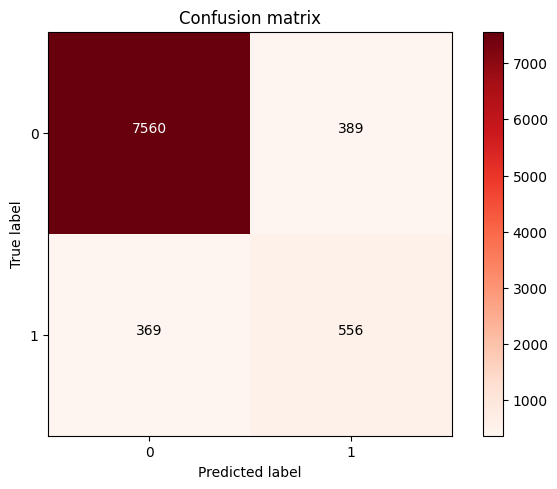

In [40]:
plot_confusion_matrix(cf)